## Configure GPU

In [1]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


## Build Xception model

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, Add, Dense, \
BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

In [3]:
# Note: Every convolutional layer is followed by a Batch Normalization layer

# Make a convolutional block (Conv2D + Batch Normalization)
def conv_bn(x, filters, kernel_size, strides = 1):
    x = Conv2D(filters = filters, kernel_size = kernel_size,
               strides = strides, padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

# Make a seperable convolutional block (Seperable Conv2D + Batch Normalization)
def sep_bn(x, filters, kernel_size, strides = 1):
    x = SeparableConv2D(filters = filters, kernel_size = kernel_size, strides = strides,
                       padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [4]:
# Construct the entry flow
def entry_flow(x):
    
    # conv_bn(x, filters, kernel_size, strides)
    x = conv_bn(x, filters = 32, kernel_size = 3, strides = 2)
    x = ReLU()(x)
    
    x = conv_bn(x, filters = 64, kernel_size = 3)
    tensor = ReLU()(x)
        
    # Normal flow
    x = sep_bn(tensor, filters = 128, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    
    # Skip connection
    tensor = conv_bn(tensor, filters = 128, kernel_size = 1, strides = 2)
    x = Add()([x, tensor])
    # End of first skip connection
    
    # Skip connection
    tensor = conv_bn(tensor, filters = 256, kernel_size = 1, strides = 2)
    
    # Normal flow
    x = ReLU()(x)
    x = sep_bn(x, filters = 256, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 256, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    x = Add()([x, tensor])
    
    # End of second skip connection
    
    # Skip connection
    tensor = conv_bn(tensor, filters = 728, kernel_size = 1, strides = 2)
    
    # Normal flow
    x = ReLU()(x)
    x = sep_bn(x, filters = 728, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 728, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    x = Add()([x, tensor])
    
    # End of third skip connection
    
    return x

In [5]:
# Construct the middle flow
# Combine output from the entry flow and the convolution layers in the middle flow
def middle_flow(tensor):
    
    for _ in range(8):
        
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        
        tensor = Add()([x, tensor])
    
    return x

In [6]:
# Stop at exit flow

def exit_flow(tensor, num_classes = 1000):

    # Normal path
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    
    # Skip connection
    tensor = conv_bn(tensor, filters = 1024, kernel_size = 1, strides = 2)
    
    # Add outputs
    x = Add()([tensor, x])
    
    x = sep_bn(x, filters = 1536, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048, kernel_size = 3)
    x = ReLU()(x)
    
    x = GlobalAvgPool2D()(x)
    x = Dense(units = num_classes, activation = 'softmax')(x)
    
    return x

In [7]:
model_inputs = Input(shape = (193,16,1))
model_outputs = exit_flow(middle_flow(entry_flow(model_inputs)), num_classes = 3876)
xception_model = Model(model_inputs, model_outputs)

# Check number of parameters
xception_model.summary()

# Check diagram of model
# plot_model(xception_model, to_file='xception_model.png', show_shapes=True, show_layer_names=True)

# Compile model - Classification
# xception_model.compile(optimizer='adam',
#      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#      metrics=['accuracy'])

2023-06-19 02:56:12.179134: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 02:56:13.025235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37975 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 193, 16, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 97, 8, 32)    288         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 97, 8, 32)   128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Trial 1 - Test with unmodified input size of (193,16,1)

In [8]:
import os

print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/xception
/home/jovyan/committed_git/datasets


In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Get dictionary of RP index and coordinates

# Open HDF5 file and access the dataset
filename = 'dataset_SNR10_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

# Close the HDF5 file
hdf5_file.close()

In [10]:
# Import dataset

features = np.load('augmented_features_10_ue1_v2_ds.npy')
labels = np.load('augmented_labels_10_ue1_v2_ds.npy')

print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

Shape of features np array: (89628, 193, 16)
Shape of labels np array: (89628,)


In [11]:
# Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)

        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
            
        # Get RMSE
        rmse = np.sqrt((err_sum/len(self.X_val)))
        print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, RMSE: {rmse}')
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import time

# print(features_transposed.shape)
# print(labels.shape)

X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Split the data using K Fold algorithm
inputs = np.concatenate((X_train, X_test), axis = 0)
targets = np.concatenate((y_train, y_test), axis = 0)
kfold = KFold(n_splits = 5, shuffle = True)

# For each of the train, test
split_no = 1
results = {}

# Perform K Fold Validation
for train, val in kfold.split(inputs, targets):
    
    # Make model
    print(f'Processing split {split_no}')
    
    split_results = {}
    # Create model
    model_inputs = Input(shape = (193,16,1))
    model_outputs = exit_flow(middle_flow(entry_flow(model_inputs)), num_classes = 3876)
    xception_model = Model(model_inputs, model_outputs)
    
    # Compile model - Classification
    # default learning rate is 1e-3 = 0.001
    xception_model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy'])
    
    # resnet18_model.summary()
    
    # Get the metrics
    val_callback = ValidationCallback(inputs[val], targets[val])
    start_time = time.time()
    hist = xception_model.fit(inputs[train], targets[train], batch_size = 32,
                              callbacks = [val_callback, tf.keras.callbacks.EarlyStopping('val_loss', patience = 3)],
                              epochs = 100)
    end_time = time.time()
    epoch_trgtime = end_time - start_time
    
    split_results['loss'] = hist.history['loss']
    split_results['accuracy'] = hist.history['accuracy']
    split_results['val_loss'] = hist.history['val_loss']
    split_results['val_accuracy'] = hist.history['val_accuracy']
    split_results['rmse'] = hist.history['rmse']
    split_results['train_time'] = epoch_trgtime
    
    print(f'Train time: {epoch_trgtime}')
    
    cur_split = 'split_' + str(split_no)
    results[cur_split] = split_results

    split_no += 1

print('All splits processed.')

Processing split 1


2023-06-19 04:42:59.484261: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 04:43:00.299998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37975 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6


Epoch 1/100


2023-06-19 04:43:06.198791: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-06-19 04:43:07.878030: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2241/2241 [==============================] - ETA: 0s - loss: 6.3982 - accuracy: 0.0293

Epoch End - Custom Validation Callback
Validation Loss: 4.167561054229736, Validation Accuracy: 0.1173156276345253, RMSE: 6.669160366106293
2241/2241 [==============================] - 53s 21ms/step - loss: 6.3982 - accuracy: 0.0293 - val_loss: 4.1676 - val_accuracy: 0.1173 - rmse: 6.6692
Epoch 2/100
2241/2241 [==============================] - ETA: 0s - loss: 2.7608 - accuracy: 0.2854

Epoch End - Custom Validation Callback
Validation Loss: 1.9653819799423218, Validation Accuracy: 0.41593217849731445, RMSE: 3.246431025550903
2241/2241 [==============================] - 46s 20ms/step - loss: 2.7608 - accuracy: 0.2854 - val_loss: 1.9654 - val_accuracy: 0.4159 - rmse: 3.2464
Epoch 3/100
2240/2241 [============================>.] - ETA: 0s - loss: 1.5236 - accuracy: 0.5144

Epoch End - Custom Validation Callback
Validation Loss: 1.1760427951812744, Validation Accuracy: 0.6099520325660706, RMSE: 2.34508

<Figure size 1440x720 with 0 Axes>

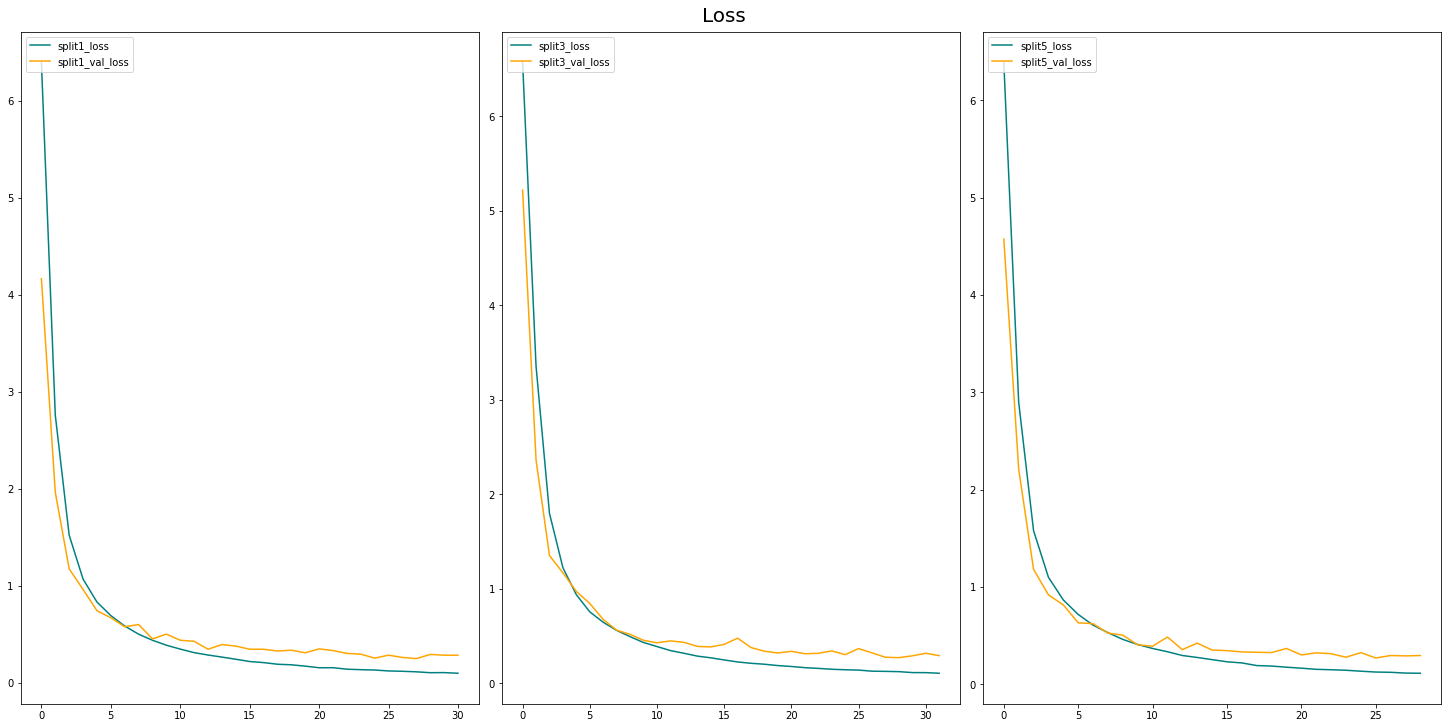

In [13]:
plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['loss'], color='teal', label='split1_loss')
axs[0].plot(results['split_1']['val_loss'], color='orange', label='split1_val_loss')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_3']['loss'], color='teal', label='split3_loss')
axs[1].plot(results['split_3']['val_loss'], color='orange', label='split3_val_loss')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_5']['loss'], color='teal', label='split5_loss')
axs[2].plot(results['split_5']['val_loss'], color='orange', label='split5_val_loss')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

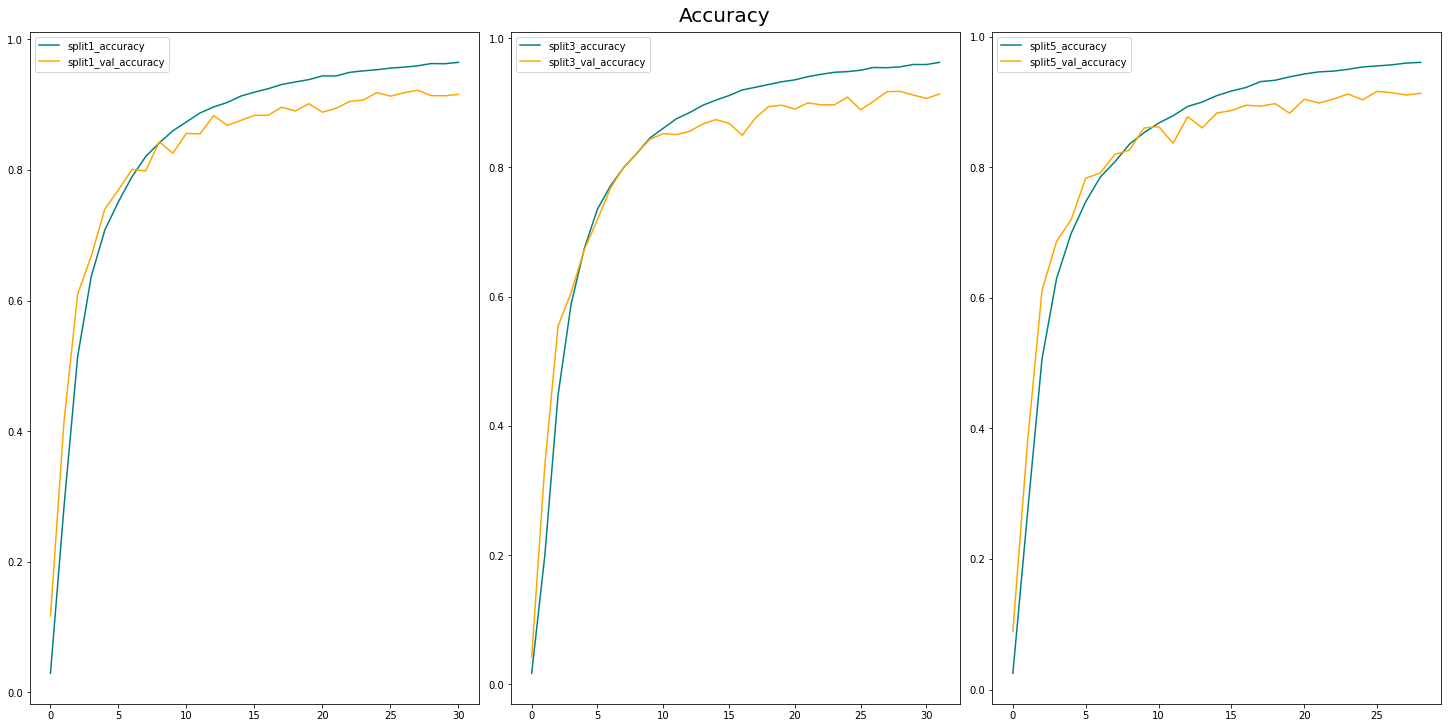

In [14]:
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['accuracy'], color='teal', label='split1_accuracy')
axs[0].plot(results['split_1']['val_accuracy'], color='orange', label='split1_val_accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_3']['accuracy'], color='teal', label='split3_accuracy')
axs[1].plot(results['split_3']['val_accuracy'], color='orange', label='split3_val_accuracy')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_5']['accuracy'], color='teal', label='split5_accuracy')
axs[2].plot(results['split_5']['val_accuracy'], color='orange', label='split5_val_accuracy')
axs[2].legend(loc='upper left')

fig.suptitle('Accuracy', fontsize=20)

plt.show()

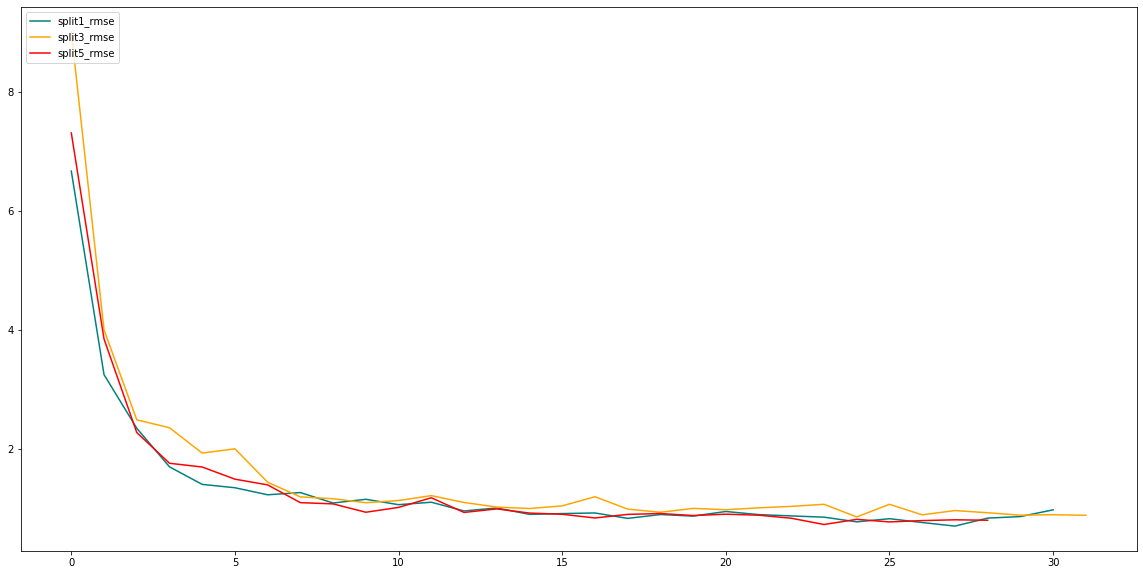

In [15]:
plt.plot(results['split_1']['rmse'], color='teal', label='split1_rmse')
plt.plot(results['split_3']['rmse'], color='orange', label='split3_rmse')
plt.plot(results['split_5']['rmse'], color='red', label='split5_rmse')
fig.suptitle('RMSE', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [16]:
ttal_time = 0

for key, items in results.items():
    ttal_time += items['train_time']
    
print(f'Average train time: {ttal_time/5}')

Average train time: 1250.4476399421692


## Build model using optimal hyperparameters

### Hyperparameters:
- fc_dropout: True
- pooling_dropout: False
- learning_rate: 0.0001
- l2_conv2d: 0.0
- l2_sepconv2d: 0.01
- batch_size: 16

In [2]:
# Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val, cur_val_loss, val_loss_threshold):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.cur_val_loss = cur_val_loss
        self.val_loss_threshold = val_loss_threshold
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
        rmse = np.sqrt((err_sum/len(self.X_val)))
       
        # Save values to log
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse
        
        # Whenever validation loss is minimised and below threshold, save the model
        # and update current minimum loss
        if val_loss < self.cur_val_loss and val_loss < self.val_loss_threshold:
            self.model.save('xception_model.h5')
            self.cur_val_loss = val_loss

In [3]:
# Build optimal model

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, Add, Dense, \
BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D, Dropout
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

# Note: Every convolutional layer is followed by a Batch Normalization layer

# Make a convolutional block (Conv2D + Batch Normalization)
def conv_bn(x, filters, kernel_size, strides = 1):
    x = Conv2D(filters = filters, kernel_size = kernel_size,
               strides = strides, padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

# Make a seperable convolutional block (Seperable Conv2D + Batch Normalization)
def sep_bn(x, filters, kernel_size, strides = 1):
    x = SeparableConv2D(filters = filters, kernel_size = kernel_size, strides = strides,
                       padding = 'same', use_bias = False,
                       kernel_regularizer = keras.regularizers.L2(l2 = 0.01))(x)
    x = BatchNormalization()(x)
    return x

# Construct the entry flow
def entry_flow(x):
    
    # conv_bn(x, filters, kernel_size, strides)
    x = conv_bn(x, filters = 32, kernel_size = 3, strides = 2)
    x = ReLU()(x)
    
    x = conv_bn(x, filters = 64, kernel_size = 3)
    tensor = ReLU()(x)
        
    # Normal flow
    x = sep_bn(tensor, filters = 128, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    
    # Skip connection
    tensor = conv_bn(tensor, filters = 128, kernel_size = 1, strides = 2)
    x = Add()([x, tensor])
    # End of first skip connection
    
    # Skip connection
    tensor = conv_bn(tensor, filters = 256, kernel_size = 1, strides = 2)
    
    # Normal flow
    x = ReLU()(x)
    x = sep_bn(x, filters = 256, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 256, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    x = Add()([x, tensor])
    
    # End of second skip connection
    
    # Skip connection
    tensor = conv_bn(tensor, filters = 728, kernel_size = 1, strides = 2)
    
    # Normal flow
    x = ReLU()(x)
    x = sep_bn(x, filters = 728, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 728, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    x = Add()([x, tensor])
    
    # End of third skip connection
    
    return x

# Construct the middle flow
# Combine output from the entry flow and the convolution layers in the middle flow
def middle_flow(tensor):
    
    for _ in range(8):
        
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        
        tensor = Add()([x, tensor])
    
    return x

# Stop at exit flow

def exit_flow(tensor, num_classes = 1000):

    # Normal path
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024, kernel_size = 3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(x)
    
    # Skip connection
    tensor = conv_bn(tensor, filters = 1024, kernel_size = 1, strides = 2)
    
    # Add outputs
    x = Add()([tensor, x])
    
    x = sep_bn(x, filters = 1536, kernel_size = 3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048, kernel_size = 3)
    x = ReLU()(x)
    
    x = GlobalAvgPool2D()(x)
    
    # Add fully connected dropout layer
    x = Dropout(rate = 0.5)(x)
    
    x = Dense(units = num_classes, activation = 'softmax')(x)
    
    return x

In [25]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
import math

class Xception:
    
    def __init__(self):
        
        # Create model
        model_inputs = Input(shape = (193,16,1))
        model_outputs = exit_flow(middle_flow(entry_flow(model_inputs)), num_classes = 3876)
        self.model = Model(inputs = model_inputs, outputs = model_outputs)

        # default learning rate is 1e-3 = 0.001, optimal learning rate is 1e-4 = 0.0001
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
        
        self.model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
        self.model.summary()
        
    def train_model(self):
    
        # In training, use model.fit() validation callback to get results on training loss, training accuracy,
        # validation loss and validation accuracy and rmse after every epoch
        val_callback = ValidationCallback(X_test, y_test, math.inf, 1)
        
        # Can leave out early stopping for now, manually observe when val_loss stops improving to determine
        # optimal number of epochs
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        hist = self.model.fit(X_train, y_train,
                              epochs = 100,
                              batch_size = 16,
                              callbacks = [val_callback, stop_early]
                             )

        return hist
    
    def calc_error(self, actual, predicted):

            x_error = (actual[0] - predicted[0])**2
            y_error = (actual[1] - predicted[1])**2
            z_error = (actual[2] - predicted[2])**2

            return x_error + y_error + z_error
    
    def calc_errorcdf(self, errors):
        
        # Sort the array
        sorted_data = np.sort(errors)

        # Calculate cumulative probabilities
        n = len(sorted_data)
        cumulative_probs = np.arange(1, n + 1) / n
    
        return (sorted_data, cumulative_probs)
        
    def test_model(self, filename):
        
        # Load model
        self.model = keras.models.load_model(filename)
        
        # In test, use model.predict() to get the RMSE errors of predictions and CDF of distance error
        y_pred = self.model.predict(X_test, verbose = 0)
        err_sum = 0
        
        dist_errors = []
        max_disterror = -math.inf
        max_disterror_actual, max_disterror_pred = None, None
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(X_test)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[y_test[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            
            # Update the maximum errror, if needed
            dist_err = np.sqrt(err)
            if dist_err > max_disterror:
                
                # Update max error
                max_disterror = dist_err
                
                # Return the class index and then retrieve actual coordinates from rp_dict
                max_disterror_actual = y_test[i]
                max_disterror_pred = predicted_rp
            
            # Append error to distance errors
            dist_errors.append(dist_err)
            err_sum += err
            
        # Get RMSE of all predicted points
        rmse = np.sqrt((err_sum/len(X_test)))
        
        # Get actual and predicted point with the largest error
        print(f'Largest error: {max_disterror}, Actual RP index: {max_disterror_actual}, Predicted RP index: {max_disterror_pred}')
        
        return (rmse, *self.calc_errorcdf(dist_errors))

In [4]:
import os

print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/xception
/home/jovyan/committed_git/datasets


In [5]:
# Get dictionary of class and reference point coordinates to calculate rmse later on

import h5py
import numpy as np
import tensorflow as tf

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
print(features_transposed.shape)
print(labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_transposed, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

print(dataset)

(3876, 193, 16)
(3876,)
<MapDataset element_spec=(TensorSpec(shape=(193, 16), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


2023-06-21 06:59:38.181060: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 06:59:38.619207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43428 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
# Import dataset

features = np.load('augmented_features_10_ue1_v2_ds.npy')
labels = np.load('augmented_labels_10_ue1_v2_ds.npy')

print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

Shape of features np array: (89628, 193, 16)
Shape of labels np array: (89628,)


In [7]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import time

# print(features_transposed.shape)
# print(labels.shape)

X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [8]:
print(os.getcwd())
os.chdir('../xception')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/xception


In [31]:
# Train model
xception_model = Xception()
trg_results = xception_model.train_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 193, 16, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 97, 8, 32)    288         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_200 (Batch  (None, 97, 8, 32)   128         ['conv2d_30[0][0]']              
 Normalization)                                                                                   
                                                                                            

In [36]:
loss = trg_results.history['loss']
acc = trg_results.history['accuracy']
val_loss = trg_results.history['val_loss']
val_acc = trg_results.history['val_accuracy']
rmse = trg_results.history['rmse']
epochs = [i for i in range(len(rmse))]

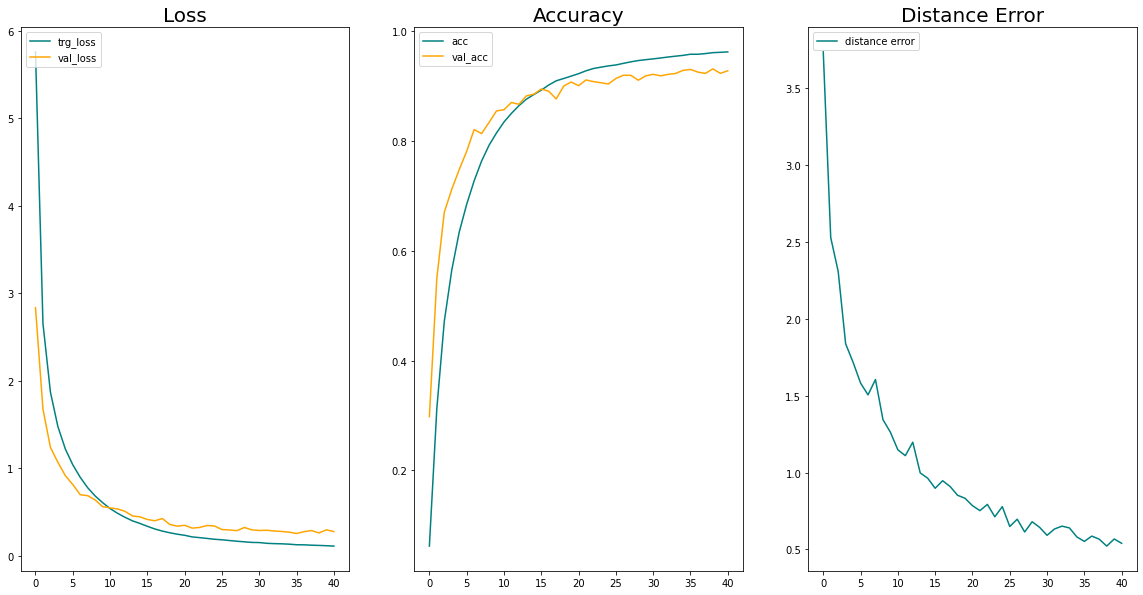

<Figure size 1440x720 with 0 Axes>

In [37]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3)

axs[0].plot(epochs, loss, color='teal', label='trg_loss')
axs[0].plot(epochs, val_loss, color='orange', label='val_loss')
axs[0].legend(loc='upper left')
axs[0].set_title('Loss', fontsize=20)

axs[1].plot(epochs, acc, color='teal', label='acc')
axs[1].plot(epochs, val_acc, color='orange', label='val_acc')
axs[1].legend(loc='upper left')
axs[1].set_title('Accuracy', fontsize=20)

axs[2].plot(epochs, rmse, color='teal', label='distance error')
axs[2].legend(loc='upper left')
axs[2].set_title('Distance Error', fontsize=20)

plt.show()

In [32]:
# Test model 
# xception_model = Xception()
rmse, dist_errors, cdf_vals = xception_model.test_model("xception_model.h5")

Largest error: 9.82344135219425, Actual RP index: 3873, Predicted RP index: 3684


In [33]:
print(rmse)

0.5523599628015056


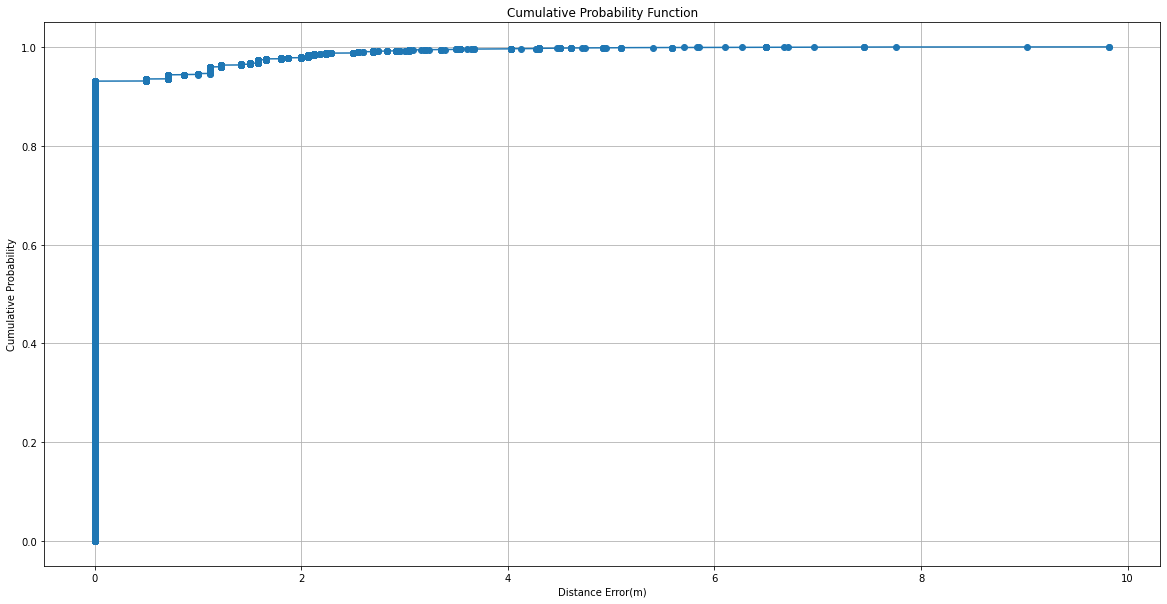

In [35]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(dist_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()

# plt.savefig('xception_cdf')

## Test to see how long it takes to train 100 epochs

In [9]:
# Same as above, but removed early stopping callback
from sklearn.model_selection import train_test_split
from tensorflow import keras
import math
import time

class Xception_v2:
    
    def __init__(self):
        
        # Create model
        model_inputs = Input(shape = (193,16,1))
        model_outputs = exit_flow(middle_flow(entry_flow(model_inputs)), num_classes = 3876)
        self.model = Model(inputs = model_inputs, outputs = model_outputs)

        # default learning rate is 1e-3 = 0.001, optimal learning rate is 1e-4 = 0.0001
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
        
        self.model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    
        self.model.summary()
        
    def train_model(self):
    
        # In training, use model.fit() validation callback to get results on training loss, training accuracy,
        # validation loss and validation accuracy and rmse after every epoch
        val_callback = ValidationCallback(X_test, y_test, math.inf, 1)
        
        # Can leave out early stopping for now, manually observe when val_loss stops improving to determine
        # optimal number of epochs
        
        # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        start_time = time.time()
        hist = self.model.fit(X_train, y_train,
                              epochs = 100,
                              batch_size = 16,
                              callbacks = [val_callback]
#                              callbacks = [val_callback, stop_early]
                             )
        
        end_time = time.time()
        print(f'Time taken to clear 100 epochs: {end_time - start_time}')
        
        return hist
    
    def calc_error(self, actual, predicted):

            x_error = (actual[0] - predicted[0])**2
            y_error = (actual[1] - predicted[1])**2
            z_error = (actual[2] - predicted[2])**2

            return x_error + y_error + z_error
    
    def calc_errorcdf(self, errors):
        
        # Sort the array
        sorted_data = np.sort(errors)

        # Calculate cumulative probabilities
        n = len(sorted_data)
        cumulative_probs = np.arange(1, n + 1) / n
    
        return (sorted_data, cumulative_probs)
        
    def test_model(self, filename):
        
        # Load model
        self.model = keras.models.load_model(filename)
        
        # In test, use model.predict() to get the RMSE errors of predictions and CDF of distance error
        y_pred = self.model.predict(X_test, verbose = 0)
        err_sum = 0
        
        dist_errors = []
        max_disterror = -math.inf
        max_disterror_actual, max_disterror_pred = None, None
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(X_test)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[y_test[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            
            # Update the maximum errror, if needed
            dist_err = np.sqrt(err)
            if dist_err > max_disterror:
                
                # Update max error
                max_disterror = dist_err
                
                # Return the class index and then retrieve actual coordinates from rp_dict
                max_disterror_actual = y_test[i]
                max_disterror_pred = predicted_rp
            
            # Append error to distance errors
            dist_errors.append(dist_err)
            err_sum += err
            
        # Get RMSE of all predicted points
        rmse = np.sqrt((err_sum/len(X_test)))
        
        # Get actual and predicted point with the largest error
        print(f'Largest error: {max_disterror}, Actual RP index: {max_disterror_actual}, Predicted RP index: {max_disterror_pred}')
        
        return (rmse, *self.calc_errorcdf(dist_errors))

In [10]:
# Train model
xception_model2 = Xception_v2()
trg_results2 = xception_model2.train_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 193, 16, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 97, 8, 32)    288         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 97, 8, 32)   128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

2023-06-21 07:00:15.523810: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-06-21 07:00:16.822192: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4482/4482 [==============================] - ETA: 0s - loss: 5.6895 - accuracy: 0.0640

Epoch End - Custom Validation Callback
4482/4482 [==============================] - 81s 17ms/step - loss: 5.6895 - accuracy: 0.0640 - val_loss: 2.7735 - val_accuracy: 0.2873 - rmse: 3.6970
Epoch 2/100
4482/4482 [==============================] - ETA: 0s - loss: 2.6504 - accuracy: 0.3089

Epoch End - Custom Validation Callback
4482/4482 [==============================] - 75s 17ms/step - loss: 2.6504 - accuracy: 0.3089 - val_loss: 1.6443 - val_accuracy: 0.5600 - rmse: 2.4356
Epoch 3/100
4482/4482 [==============================] - ETA: 0s - loss: 1.8605 - accuracy: 0.4743

Epoch End - Custom Validation Callback
4482/4482 [==============================] - 74s 17ms/step - loss: 1.8605 - accuracy: 0.4743 - val_loss: 1.2303 - val_accuracy: 0.6626 - rmse: 2.0105
Epoch 4/100
4481/4482 [============================>.] - ETA: 0s - loss: 1.4708 - accuracy: 0.5670

Epoch End - Custom Validation Callback
4482/4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4479/4482 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9436

Epoch End - Custom Validation Callback
4482/4482 [==============================] - 76s 17ms/step - loss: 0.1678 - accuracy: 0.9436 - val_loss: 0.2734 - val_accuracy: 0.9251 - rmse: 0.6148
Epoch 29/100
4479/4482 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9459

Epoch End - Custom Validation Callback
4482/4482 [==============================] - 76s 17ms/step - loss: 0.1602 - accuracy: 0.9459 - val_loss: 0.3165 - val_accuracy: 0.9092 - rmse: 0.6792
Epoch 30/100
3462/4482 [======================>.......] - ETA: 15s - loss: 0.1498 - accuracy: 0.9493

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4479/4482 [============================>.] - ETA: 0s - loss: 0.1064 - accuracy: 0.9639

Epoch End - Custom Validation Callback
4482/4482 [==============================] - 76s 17ms/step - loss: 0.1064 - accuracy: 0.9638 - val_loss: 0.2400 - val_accuracy: 0.9348 - rmse: 0.4994
Epoch 43/100
4482/4482 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9664

Epoch End - Custom Validation Callback
4482/4482 [==============================] - 75s 17ms/step - loss: 0.1032 - accuracy: 0.9664 - val_loss: 0.2651 - val_accuracy: 0.9285 - rmse: 0.5895
Epoch 44/100
4480/4482 [============================>.] - ETA: 0s - loss: 0.1006 - accuracy: 0.9661

Epoch End - Custom Validation Callback
4482/4482 [==============================] - 75s 17ms/step - loss: 0.1006 - accuracy: 0.9661 - val_loss: 0.2438 - val_accuracy: 0.9355 - rmse: 0.5255
Epoch 45/100
4480/4482 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.9670

Epoch End - Custom Validation Callback
448

In [26]:
loss = trg_results2.history['loss']
acc = trg_results2.history['accuracy']
val_loss = trg_results2.history['val_loss']
val_acc = trg_results2.history['val_accuracy']
rmse = trg_results2.history['rmse']
epochs = [i for i in range(len(rmse))]

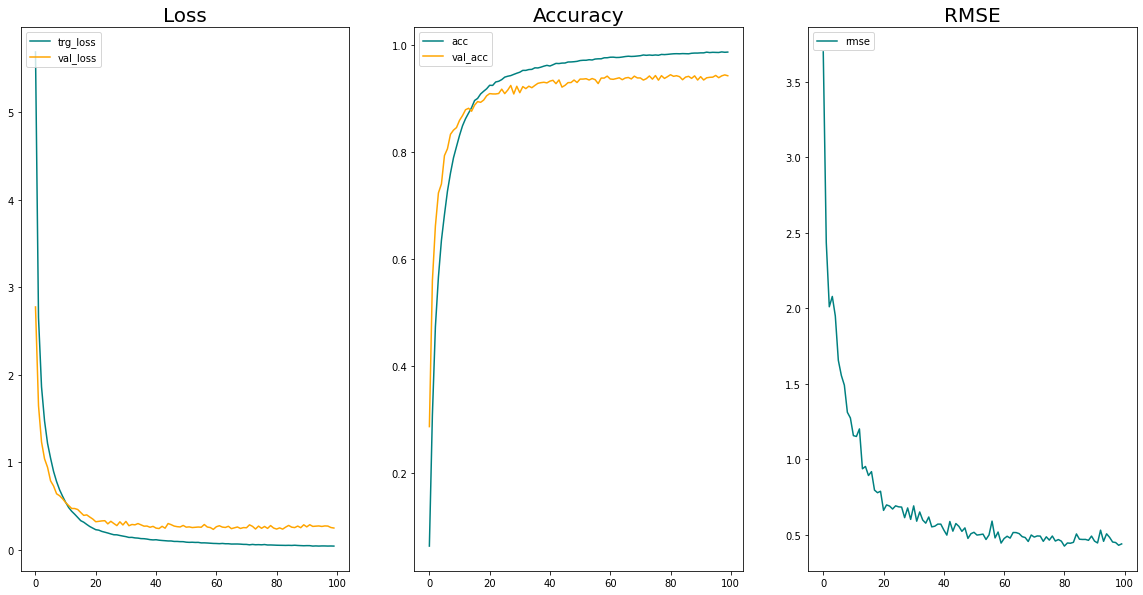

In [27]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3)

axs[0].plot(epochs, loss, color='teal', label='trg_loss')
axs[0].plot(epochs, val_loss, color='orange', label='val_loss')
axs[0].legend(loc='upper left')
axs[0].set_title('Loss', fontsize=20)

axs[1].plot(epochs, acc, color='teal', label='acc')
axs[1].plot(epochs, val_acc, color='orange', label='val_acc')
axs[1].legend(loc='upper left')
axs[1].set_title('Accuracy', fontsize=20)

axs[2].plot(epochs, rmse, color='teal', label='rmse')
axs[2].legend(loc='upper left')
axs[2].set_title('RMSE', fontsize=20)

plt.show()

In [20]:
val_loss = np.array(val_loss)
print(f'Minimum loss: {val_loss.min()}')
best_epoch = np.where(val_loss == val_loss.min())[0][0]

print(f'Best Epoch no: {best_epoch}')
print(f'Best val loss: {val_loss[best_epoch]}, Best val acc: {val_acc[best_epoch]}')
print(f'Best trg loss: {loss[best_epoch]}, Best trg acc: {acc[best_epoch]}')

Minimum loss: 0.23021122813224792
Checking minimum loss: 0.23021122813224792
Best Epoch no: 59
Best val loss: 0.23021122813224792, Best val acc: 0.9425973296165466
Best trg loss: 0.0695846676826477, Best trg acc: 0.976946234703064


In [22]:
# Test model 
# xception_model = Xception()
rmse, dist_errors, cdf_vals = xception_model2.test_model("xception_model.h5")

Largest error: 7.632168761236874, Actual RP index: 3451, Predicted RP index: 3736


In [23]:
print(rmse)

0.44667065207709533


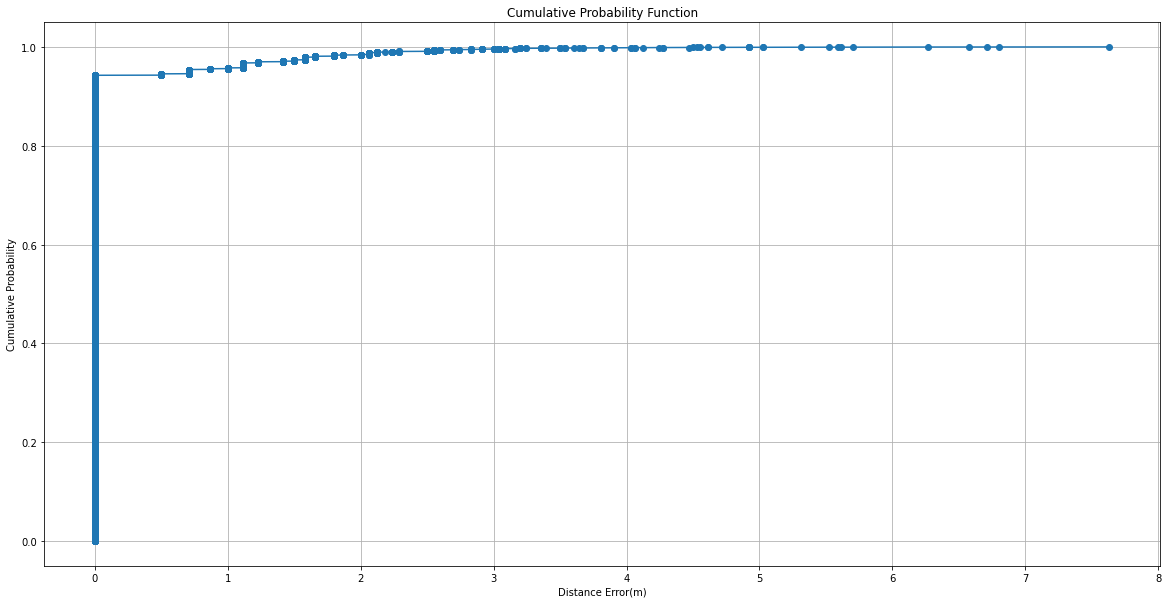

In [24]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(dist_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()

## Test with unmodified input size of (193,16,3)
- Fingerprints (considered grayscale as only have one channel) are converted into 3 channels. (193,16,1) --> (193,16,3)

In [20]:
print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

new_shape = (*features.shape, 3)
features_3channels = np.zeros(shape=new_shape, dtype = np.float64)

for feature in features:
    features_3channels[i] = np.stack((feature,)*3, axis = -1)
    
print(f'Reshaped features shape: {features_3channels.shape}')

Shape of features np array: (83008, 193, 16)
Shape of labels np array: (83008,)
Reshaped features shape: (83008, 193, 16, 3)


In [ ]:
# Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)

        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
            
        # Get RMSE
        rmse = np.sqrt((err_sum/len(self.X_val)))
        print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, RMSE: {rmse}')
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse

In [ ]:
# Build a tensorflow dataset pipeline since data is too big
# Make dataset -> shuffle -> split -> batch -> prefetch
# During training, take in the train datraset in batches and at the end of each batch, 
import time

# Make a tf dataset
dataset = tf.data.Dataset.from_tensor_slices((features_3channels, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

# Instantiate model
model_inputs = Input(shape = (193,16,1))
model_outputs = exit_flow(middle_flow(entry_flow(model_inputs)), num_classes = 3876)
xception_model = Model(model_inputs, model_outputs)

# Compile model - Classification
# default learning rate is 1e-3 = 0.001
xception_model.compile(optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=['accuracy'])

num_epochs = 100
results = {}

# For each epoch until limit reached
# Track start time
start_time = time.time()

for i in range(num_epochs):
    
    print(f'Processing Epoch {i+1}')
    
    # Shuffle the dataset
    shuffled_ds = dataset.shuffle(buffer_size = 180000)
    
    # Split the dataset
    size = len(dataset)
    train_size = round(0.8 * size)
    val_size = round(0.1 * size)
    test_size = round(0.1 * size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size).take(test_size)
    
    # Batch datasets
    batched_train_dataset = train_dataset.batch(8000, drop_remainder = True)
    
    # Dictionary for current epoch results
    epoch_results = {'trg_loss': [], 'trg_accuracy': [], 'val_loss': [], 'val_accuracy': [], 'rmse': []}
    
    # For each batch
    for features, labels in batched_train_dataset:
        
        # Extract validation data 
        val_features, val_labels = None, None
        for f, l in val_dataset:
            val_features = f
            val_labels = l
        val_callback = ValidationCallback(val_features, val_labels)
        
        # Fit the model on the batch
        hist = xception_model.fit(features, labels, batch_size = 32,
                              callbacks = [val_callback],
                              epochs = 1)
        
        # Evaluate model at the end of every batch of train data
        # In the end, will get a continuous plot across epochs and within each epochs, have 10 plot points corresponding to each batch of train data
        epoch_results['loss'].append(hist.history['loss'])
        epoch_results['accuracy'].append(hist.history['accuracy'])
        epoch_results['val_loss'].append(hist.history['val_loss'])
        epoch_results['val_accuracy'].append(hist.history['val_accuracy'])
        epoch_results['rmse'].append(hist.history['rmse'])
        
    epoch_no = 'epoch' + str(i+1)
    results[epoch_no] = epoch_results
    
end_time = time.time()
train_time = end_time - start_time